In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import newton, fsolve

### Definition of the forced Van der Pol oscillator

In [3]:
def vdp(t,y,epsilon,A,T):
    F = 1./T
    return np.array([
        y[1],
        epsilon*(1-y[0]**2)*y[1] - y[0] + A*np.cos(2*np.pi*F*t)
    ])
def vdp_jac(t,y,epsilon):
    return np.array([
        [0,1],
        [-2*epsilon*y[0]*y[1]-1,epsilon*(1-y[0]**2)]
    ])
def y1min(t,y):
    return y[1]
y1min.direction = 1

#### Verify that the (rescaled) period is unitary

In [4]:
autonomous = False
epsilon = 0.001
if autonomous:
    T = 2*np.pi
    A = 0
else:
    A = 1.2
    T = 10.
tend = 1500.
y0_ref = np.array([2,-3])
#y0_ref = np.array([2e-3,0])
reltol = 1e-6
abstol = 1e-8*np.ones(y0_ref.shape)
ref = solve_ivp(lambda t,y: T*vdp(t*T,y,epsilon,A,T),[0,tend],y0_ref,
                    method='BDF',jac=lambda t,y: vdp_jac(t,y,epsilon),
                    events=y1min,atol=abstol,rtol=reltol)

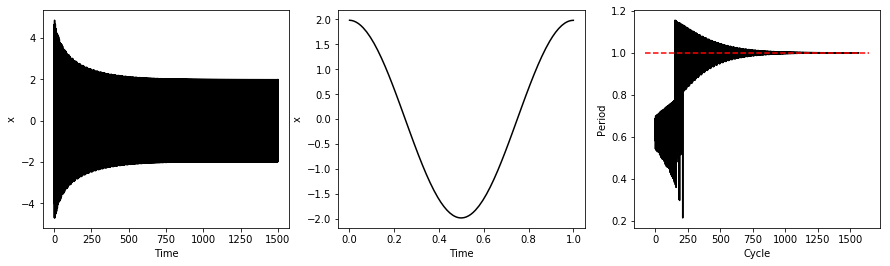

In [5]:
plt.figure(figsize=[15,4])
plt.subplot(1,3,1)
plt.plot(ref['t'],ref['y'][0,:],'k')
plt.xlabel('Time')
plt.ylabel('x')
#
idx = ref['t'] >= tend-1
plt.subplot(1,3,2)
plt.plot(ref['t'][idx]-tend+1,ref['y'][0,idx],'k')
plt.xlabel('Time')
plt.ylabel('x')
#
plt.subplot(1,3,3)
plt.plot(np.diff(ref['t_events'][0]),'k')
plt.plot(plt.xlim(),[1,1],'r--')
plt.xlabel('Cycle')
plt.ylabel('Period')
plt.show()

In [53]:
def shooting_extended_system(t,y,fun,jac,T,autonomous):
    if autonomous:
        N = int(np.max(np.roots([1,2,-len(y)])))
    else:        
        N = int(np.max(np.roots([1,1,-len(y)])))
    J = jac(t,y[:N])
    phi = np.reshape(y[N:N+N**2],(N,N))
    ydot = np.concatenate((T*fun(t*T,y[:N]),T*np.matmul(J,phi).flatten()))
    if autonomous:
        dxdt = y[-N:]
        ydot = np.concatenate((ydot,T*np.matmul(J,dxdt)+fun(t,y[:N])))
    return ydot

def shooting(fun,jac,y0_guess,T_guess,autonomous,max_iter=100,rtol=1e-6,atol=None,do_plot=False):
    # original number of dimensions of the system
    N = len(y0_guess)
    # number of dimensions of the extended system
    N_ext = N**2 + N
    X = y0_guess
    if autonomous:
        N_ext += N
        X = np.append(X,T_guess)
    else:
        # the period is fixed if the system is non-autonomous
        T = T_guess
    if atol is None:
        atol = 1e-8 + np.zeros(N_ext)
    for i in range(max_iter):
        #print('y0 = (%f,%f)' % (X[0],X[1]))
        y0_ext = np.concatenate((X[:N],np.eye(N).flatten()))
        if autonomous:
            y0_ext = np.concatenate((y0_ext,np.zeros(N)))
            T = X[-1]
        sol = solve_ivp(lambda t,y: shooting_extended_system(t,y,fun,jac,T,autonomous),
                        [0,1], y0_ext, method='BDF', atol=atol, rtol=rtol)
        r = map(lambda x: x[-1]-x[0], sol['y'][:N])
        phi = np.reshape(sol['y'][N:N**2+N,-1],(N,N))
        if autonomous:
            b = sol['y'][-N:,-1]
            M = np.zeros((N+1,N+1))
            M[:N,:N] = phi - np.eye(N)
            M[:N,-1] = b
            M[-1,:N] = b
            r = np.append(r,0.)
        else:
            M = phi - np.eye(N)
        X_new = X - np.matmul(inv(M),r)
        if do_plot:
            if i == 0:
                plt.subplot(1,2,2)
                plt.plot(sol['y'][1,:],sol['y'][0,:],'r')
                plt.subplot(1,2,1)
                plt.plot(sol['t'],sol['y'][0,:],'r')
            else:
                if np.max(np.abs(X_new-X)) < 1e-8:
                    plt.plot(sol['t'],sol['y'][0,:],'k')
                else:
                    plt.plot(sol['t'],sol['y'][0,:])
        if np.max(np.abs(X_new-X)) < 1e-8:
            break
        X = X_new
    if do_plot:
        plt.xlabel('Time')
        plt.ylabel('x')
        plt.subplot(1,2,2)
        plt.plot(sol['y'][1,:],sol['y'][0,:],'k')
        plt.xlabel('y')
        plt.show()
    #print('Performed %d iterations.' % (i+1))
    if autonomous:
        return X[:N],X[-1],phi,i+1
    return X,phi,i+1

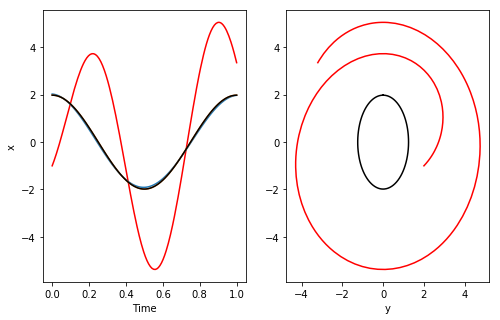

Number of iterations: 4.


In [57]:
autonomous = False
T = 10.
A = 1.2
y0_guess = [-1,2]
plt.figure(figsize=(8,5))
y0_opt,phi,n_iter = shooting(lambda t,y: vdp(t,y,epsilon,A,T), lambda t,y: vdp_jac(t,y,epsilon), 
                             y0_guess, T, autonomous, do_plot=True)
print('Number of iterations: %d.' % n_iter)

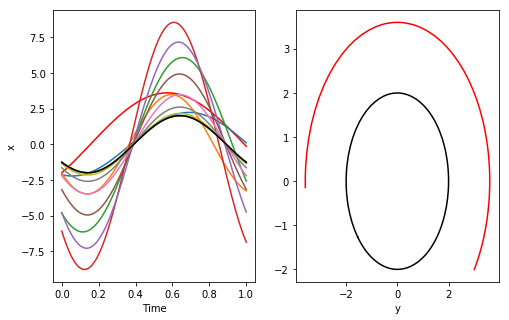

T = 6.28318.
Number of iterations: 14.


In [56]:
autonomous = True
T = 2*np.pi
A = 0
y0_guess = [-2,3]
T_guess = 0.6*T
plt.figure(figsize=(8,5))
y0_opt,T,phi,n_iter = shooting(lambda t,y: vdp(t,y,epsilon,A,T), lambda t,y: vdp_jac(t,y,epsilon), 
                               y0_guess, T_guess, autonomous, do_plot=True)
print('T = %g.' % T)
print('Number of iterations: %d.' % n_iter)